In [1]:
import torch
import torchvision
import random
import numpy as np
import matplotlib.pyplot as plt

# to re-load loaddata,helper and model if changes happened 
%load_ext autoreload
%autoreload 2

from torch import nn
from torch import optim
from torchvision import transforms
from torch.utils.data import DataLoader
from loaddata import FacialKeyPointsDataset , Rescale , Normalize , RandomCrop , ToTensor
from helper import show_keypoints , visualize_output , StopEarly
from model import Net


In [2]:
model = Net().cuda()
print(model)

Net(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): MaxPool2d(kernel_size=2, stride=2, padd

In [3]:
tranform = transforms.Compose([Rescale(250),RandomCrop(224),Normalize(),ToTensor()])
batch_size = 20
# train data
traindata = FacialKeyPointsDataset('data/training/','data/training_frames_keypoints.csv',transform=tranform)
train_loader = DataLoader(traindata,batch_size=batch_size,shuffle=True)
#test Data
testdata = FacialKeyPointsDataset('data/test/','data/test_frames_keypoints.csv',transform=tranform)
test_loader = DataLoader(testdata,batch_size=batch_size,shuffle=True)

In [4]:
# some Info about data 
print("Number of training images is : ",len(traindata))
print("shape of training images is :",traindata[0][0].shape)
print("Number if test images is :",len(testdata))

Number of training images is :  3462
shape of training images is : (1, 224, 224)
Number if test images is : 770


### test mode  in test data before training 

In [5]:
iterator = iter(test_loader)
images , keypts = iterator.next()
images , keypts = images.type(torch.cuda.FloatTensor), keypts.type(torch.cuda.FloatTensor)
outs = model(images)

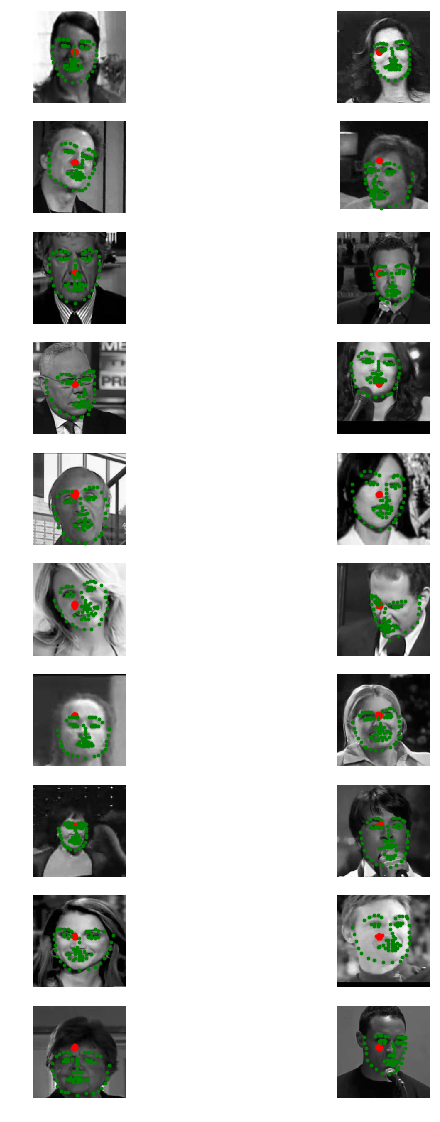

In [6]:
# plot results 
visualize_output(images,outs,batch_size,gt=keypts,gray=True)

In [5]:
# set training parameters 
cost = nn.MSELoss()
opt = optim.SGD(model.parameters(),lr=0.01,momentum=0.9,nesterov=True)

In [6]:
def train_net(n_epochs):

    # prepare the net for training
    model.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        epoch_loss = 0.0
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images ,keypts = data

            # flatten pts
            keypts = keypts.view(keypts.size(0), -1)

            # convert variables to floats for regression loss
            keypts = keypts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)

            # forward pass to get outputs
            output_pts = model(images)

            # calculate the loss between predicted and target keypoints
            loss = cost(output_pts, keypts)

            # zero the parameter (weight) gradients
            opt.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            opt.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            epoch_loss += running_loss
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0
        print('----------------\nEpoch loss: {}\n------------\n'.format(epoch_loss/170))
        if stop_early(model,epoch_loss/170) :
            print("Early stop activated ... stoping training process..")
            break
    print('Finished Training')


In [10]:
torch.cuda.empty_cache()

In [12]:
epoches = 100 
stop_early = StopEarly()
train_net(epoches)

Epoch: 1, Batch: 10, Avg. Loss: 0.1557600013911724
Epoch: 1, Batch: 20, Avg. Loss: 0.17584796249866486
Epoch: 1, Batch: 30, Avg. Loss: 0.20022993683815002
Epoch: 1, Batch: 40, Avg. Loss: 0.176941978931427
Epoch: 1, Batch: 50, Avg. Loss: 0.19981661736965178
Epoch: 1, Batch: 60, Avg. Loss: 0.1824672505259514
Epoch: 1, Batch: 70, Avg. Loss: 0.17132607251405715
Epoch: 1, Batch: 80, Avg. Loss: 0.18410236537456512
Epoch: 1, Batch: 90, Avg. Loss: 0.20527733638882636
Epoch: 1, Batch: 100, Avg. Loss: 0.17825339883565902
Epoch: 1, Batch: 110, Avg. Loss: 0.14618424624204635
Epoch: 1, Batch: 120, Avg. Loss: 0.16466460302472113
Epoch: 1, Batch: 130, Avg. Loss: 0.15496473982930184
Epoch: 1, Batch: 140, Avg. Loss: 0.15570973455905915
Epoch: 1, Batch: 150, Avg. Loss: 0.1688877560198307
Epoch: 1, Batch: 160, Avg. Loss: 0.15508817434310912
Epoch: 1, Batch: 170, Avg. Loss: 0.18256245851516723
----------------
Epoch loss: 0.9740129597485065
------------

Epoch: 2, Batch: 10, Avg. Loss: 0.1860920086503029


Epoch: 9, Batch: 20, Avg. Loss: 0.04791024997830391
Epoch: 9, Batch: 30, Avg. Loss: 0.04289358556270599
Epoch: 9, Batch: 40, Avg. Loss: 0.05654405280947685
Epoch: 9, Batch: 50, Avg. Loss: 0.0853016957640648
Epoch: 9, Batch: 60, Avg. Loss: 0.06396511234343052
Epoch: 9, Batch: 70, Avg. Loss: 0.07109830528497696
Epoch: 9, Batch: 80, Avg. Loss: 0.04626384824514389
Epoch: 9, Batch: 90, Avg. Loss: 0.04725194051861763
Epoch: 9, Batch: 100, Avg. Loss: 0.0637244213372469
Epoch: 9, Batch: 110, Avg. Loss: 0.050599288567900656
Epoch: 9, Batch: 120, Avg. Loss: 0.06452546305954457
Epoch: 9, Batch: 130, Avg. Loss: 0.04573514629155397
Epoch: 9, Batch: 140, Avg. Loss: 0.047012392058968545
Epoch: 9, Batch: 150, Avg. Loss: 0.10170340538024902
Epoch: 9, Batch: 160, Avg. Loss: 0.07357964888215066
Epoch: 9, Batch: 170, Avg. Loss: 0.05739704146981239
----------------
Epoch loss: 0.31873248079243827
------------

We get new best loss: 54.18452173471451 , saving model...
model saved.
Epoch: 10, Batch: 10, Avg.

Epoch: 17, Batch: 20, Avg. Loss: 0.03610445912927389
Epoch: 17, Batch: 30, Avg. Loss: 0.033839153312146666
Epoch: 17, Batch: 40, Avg. Loss: 0.04830618314445019
Epoch: 17, Batch: 50, Avg. Loss: 0.030530980601906777
Epoch: 17, Batch: 60, Avg. Loss: 0.03629646822810173
Epoch: 17, Batch: 70, Avg. Loss: 0.03379056602716446
Epoch: 17, Batch: 80, Avg. Loss: 0.033786734007298945
Epoch: 17, Batch: 90, Avg. Loss: 0.06809970699250698
Epoch: 17, Batch: 100, Avg. Loss: 0.028709252551198005
Epoch: 17, Batch: 110, Avg. Loss: 0.033773317374289034
Epoch: 17, Batch: 120, Avg. Loss: 0.06978484857827424
Epoch: 17, Batch: 130, Avg. Loss: 0.035852530226111415
Epoch: 17, Batch: 140, Avg. Loss: 0.03613173272460699
Epoch: 17, Batch: 150, Avg. Loss: 0.029216680303215982
Epoch: 17, Batch: 160, Avg. Loss: 0.03430330380797386
Epoch: 17, Batch: 170, Avg. Loss: 0.05701136030256748
----------------
Epoch loss: 0.21676457970238783
------------

We get new best loss: 36.84997854940593 , saving model...
model saved.
Epo

Epoch: 25, Batch: 20, Avg. Loss: 0.02601863071322441
Epoch: 25, Batch: 30, Avg. Loss: 0.02307238020002842
Epoch: 25, Batch: 40, Avg. Loss: 0.030677373334765435
Epoch: 25, Batch: 50, Avg. Loss: 0.0248329633846879
Epoch: 25, Batch: 60, Avg. Loss: 0.05482378620654345
Epoch: 25, Batch: 70, Avg. Loss: 0.06854660250246525
Epoch: 25, Batch: 80, Avg. Loss: 0.04157387483865023
Epoch: 25, Batch: 90, Avg. Loss: 0.03276120536029339
Epoch: 25, Batch: 100, Avg. Loss: 0.027888608910143376
Epoch: 25, Batch: 110, Avg. Loss: 0.025001773610711098
Epoch: 25, Batch: 120, Avg. Loss: 0.03333994094282389
Epoch: 25, Batch: 130, Avg. Loss: 0.0269443666562438
Epoch: 25, Batch: 140, Avg. Loss: 0.025050825625658035
Epoch: 25, Batch: 150, Avg. Loss: 0.02644239580258727
Epoch: 25, Batch: 160, Avg. Loss: 0.02220922280102968
Epoch: 25, Batch: 170, Avg. Loss: 0.021261066012084485
----------------
Epoch loss: 0.17889562020735705
------------

no improvement for 1 / 10..
Epoch: 26, Batch: 10, Avg. Loss: 0.021438106708228

Epoch: 33, Batch: 20, Avg. Loss: 0.03348535913974047
Epoch: 33, Batch: 30, Avg. Loss: 0.022121804021298885
Epoch: 33, Batch: 40, Avg. Loss: 0.024963964149355887
Epoch: 33, Batch: 50, Avg. Loss: 0.017938580922782422
Epoch: 33, Batch: 60, Avg. Loss: 0.019555598869919776
Epoch: 33, Batch: 70, Avg. Loss: 0.025397570710629223
Epoch: 33, Batch: 80, Avg. Loss: 0.021901571843773126
Epoch: 33, Batch: 90, Avg. Loss: 0.01967707499861717
Epoch: 33, Batch: 100, Avg. Loss: 0.020635013561695816
Epoch: 33, Batch: 110, Avg. Loss: 0.02439210331067443
Epoch: 33, Batch: 120, Avg. Loss: 0.017878653667867183
Epoch: 33, Batch: 130, Avg. Loss: 0.02145168650895357
Epoch: 33, Batch: 140, Avg. Loss: 0.018978788610547782
Epoch: 33, Batch: 150, Avg. Loss: 0.017579422052949666
Epoch: 33, Batch: 160, Avg. Loss: 0.04221686162054539
Epoch: 33, Batch: 170, Avg. Loss: 0.02468657698482275
----------------
Epoch loss: 0.1278118698255104
------------

We get new best loss: 21.72801787033677 , saving model...
model saved.
E

Epoch: 41, Batch: 20, Avg. Loss: 0.034309872705489394
Epoch: 41, Batch: 30, Avg. Loss: 0.017954621836543082
Epoch: 41, Batch: 40, Avg. Loss: 0.016657251678407193
Epoch: 41, Batch: 50, Avg. Loss: 0.017174689285457134
Epoch: 41, Batch: 60, Avg. Loss: 0.016174299735575916
Epoch: 41, Batch: 70, Avg. Loss: 0.014801699109375477
Epoch: 41, Batch: 80, Avg. Loss: 0.0155297570861876
Epoch: 41, Batch: 90, Avg. Loss: 0.020949080213904382
Epoch: 41, Batch: 100, Avg. Loss: 0.03663083296269178
Epoch: 41, Batch: 110, Avg. Loss: 0.02162863053381443
Epoch: 41, Batch: 120, Avg. Loss: 0.015202194824814797
Epoch: 41, Batch: 130, Avg. Loss: 0.014809738844633102
Epoch: 41, Batch: 140, Avg. Loss: 0.016536046285182238
Epoch: 41, Batch: 150, Avg. Loss: 0.01607129964977503
Epoch: 41, Batch: 160, Avg. Loss: 0.018544279504567385
Epoch: 41, Batch: 170, Avg. Loss: 0.019131295196712018
----------------
Epoch loss: 0.1024388814564137
------------

We get new best loss: 17.414609847590327 , saving model...
model saved.

Epoch: 49, Batch: 20, Avg. Loss: 0.01394938286393881
Epoch: 49, Batch: 30, Avg. Loss: 0.034147082362324
Epoch: 49, Batch: 40, Avg. Loss: 0.020357327442616223
Epoch: 49, Batch: 50, Avg. Loss: 0.04033614564687014
Epoch: 49, Batch: 60, Avg. Loss: 0.015015247371047735
Epoch: 49, Batch: 70, Avg. Loss: 0.023533460032194854
Epoch: 49, Batch: 80, Avg. Loss: 0.023263561073690653
Epoch: 49, Batch: 90, Avg. Loss: 0.018356937821954487
Epoch: 49, Batch: 100, Avg. Loss: 0.017284688539803028
Epoch: 49, Batch: 110, Avg. Loss: 0.014822867140173912
Epoch: 49, Batch: 120, Avg. Loss: 0.013225964829325676
Epoch: 49, Batch: 130, Avg. Loss: 0.014123233035206795
Epoch: 49, Batch: 140, Avg. Loss: 0.014951839204877615
Epoch: 49, Batch: 150, Avg. Loss: 0.01608470790088177
Epoch: 49, Batch: 160, Avg. Loss: 0.017088282201439143
Epoch: 49, Batch: 170, Avg. Loss: 0.014435751270502806
----------------
Epoch loss: 0.11484372597735594
------------

no improvement for 4 / 10..
Epoch: 50, Batch: 10, Avg. Loss: 0.01889248

Epoch: 57, Batch: 20, Avg. Loss: 0.015373354963958263
Epoch: 57, Batch: 30, Avg. Loss: 0.015805196948349476
Epoch: 57, Batch: 40, Avg. Loss: 0.021243471838533878
Epoch: 57, Batch: 50, Avg. Loss: 0.01539464658126235
Epoch: 57, Batch: 60, Avg. Loss: 0.028805223666131495
Epoch: 57, Batch: 70, Avg. Loss: 0.015534998290240765
Epoch: 57, Batch: 80, Avg. Loss: 0.02028404027223587
Epoch: 57, Batch: 90, Avg. Loss: 0.01552950805053115
Epoch: 57, Batch: 100, Avg. Loss: 0.012797664478421211
Epoch: 57, Batch: 110, Avg. Loss: 0.029750701133161785
Epoch: 57, Batch: 120, Avg. Loss: 0.017494527157396078
Epoch: 57, Batch: 130, Avg. Loss: 0.016259540151804686
Epoch: 57, Batch: 140, Avg. Loss: 0.012528121378272772
Epoch: 57, Batch: 150, Avg. Loss: 0.015768047701567412
Epoch: 57, Batch: 160, Avg. Loss: 0.02396020442247391
Epoch: 57, Batch: 170, Avg. Loss: 0.013425441551953554
----------------
Epoch loss: 0.10548224450801225
------------

no improvement for 1 / 10..
Epoch: 58, Batch: 10, Avg. Loss: 0.016542

Epoch: 65, Batch: 20, Avg. Loss: 0.015183649212121963
Epoch: 65, Batch: 30, Avg. Loss: 0.015079376008361577
Epoch: 65, Batch: 40, Avg. Loss: 0.01188239036127925
Epoch: 65, Batch: 50, Avg. Loss: 0.011796947475522757
Epoch: 65, Batch: 60, Avg. Loss: 0.012217726185917854
Epoch: 65, Batch: 70, Avg. Loss: 0.011117010284215212
Epoch: 65, Batch: 80, Avg. Loss: 0.01321059102192521
Epoch: 65, Batch: 90, Avg. Loss: 0.011991405952721834
Epoch: 65, Batch: 100, Avg. Loss: 0.013101201970130205
Epoch: 65, Batch: 110, Avg. Loss: 0.012643516575917602
Epoch: 65, Batch: 120, Avg. Loss: 0.023374482151120902
Epoch: 65, Batch: 130, Avg. Loss: 0.014192482363432646
Epoch: 65, Batch: 140, Avg. Loss: 0.013639120757579804
Epoch: 65, Batch: 150, Avg. Loss: 0.01121221948415041
Epoch: 65, Batch: 160, Avg. Loss: 0.011342910956591368
Epoch: 65, Batch: 170, Avg. Loss: 0.023311753943562507
----------------
Epoch loss: 0.08259574885425322
------------

no improvement for 2 / 10..
Epoch: 66, Batch: 10, Avg. Loss: 0.02065

Epoch: 73, Batch: 30, Avg. Loss: 0.01590470168739557
Epoch: 73, Batch: 40, Avg. Loss: 0.015762889571487904
Epoch: 73, Batch: 50, Avg. Loss: 0.025038041826337575
Epoch: 73, Batch: 60, Avg. Loss: 0.021123734954744577
Epoch: 73, Batch: 70, Avg. Loss: 0.013012323714792728
Epoch: 73, Batch: 80, Avg. Loss: 0.012601955607533456
Epoch: 73, Batch: 90, Avg. Loss: 0.014919630065560342
Epoch: 73, Batch: 100, Avg. Loss: 0.013928681053221226
Epoch: 73, Batch: 110, Avg. Loss: 0.013928006635978818
Epoch: 73, Batch: 120, Avg. Loss: 0.01144323032349348
Epoch: 73, Batch: 130, Avg. Loss: 0.012086131889373065
Epoch: 73, Batch: 140, Avg. Loss: 0.011307916603982449
Epoch: 73, Batch: 150, Avg. Loss: 0.023529515974223612
Epoch: 73, Batch: 160, Avg. Loss: 0.02182484157383442
Epoch: 73, Batch: 170, Avg. Loss: 0.013296378403902053
----------------
Epoch loss: 0.11010030607473763
------------

no improvement for 1 / 10..
Epoch: 74, Batch: 10, Avg. Loss: 0.012926143128424883
Epoch: 74, Batch: 20, Avg. Loss: 0.01224

Epoch: 81, Batch: 40, Avg. Loss: 0.00994614427909255
Epoch: 81, Batch: 50, Avg. Loss: 0.012977303750813008
Epoch: 81, Batch: 60, Avg. Loss: 0.012023864034563302
Epoch: 81, Batch: 70, Avg. Loss: 0.01148229232057929
Epoch: 81, Batch: 80, Avg. Loss: 0.011537858238443732
Epoch: 81, Batch: 90, Avg. Loss: 0.011113097425550222
Epoch: 81, Batch: 100, Avg. Loss: 0.015790822729468346
Epoch: 81, Batch: 110, Avg. Loss: 0.01227874243631959
Epoch: 81, Batch: 120, Avg. Loss: 0.01106453170068562
Epoch: 81, Batch: 130, Avg. Loss: 0.012139676697552204
Epoch: 81, Batch: 140, Avg. Loss: 0.010695930756628513
Epoch: 81, Batch: 150, Avg. Loss: 0.011002588085830212
Epoch: 81, Batch: 160, Avg. Loss: 0.009561811527237295
Epoch: 81, Batch: 170, Avg. Loss: 0.010016744444146752
----------------
Epoch loss: 0.06785015521625824
------------

We get new best loss: 11.5345263867639 , saving model...
model saved.
Epoch: 82, Batch: 10, Avg. Loss: 0.010547534096986055
Epoch: 82, Batch: 20, Avg. Loss: 0.010568861849606037

Epoch: 89, Batch: 20, Avg. Loss: 0.01703096479177475
Epoch: 89, Batch: 30, Avg. Loss: 0.011503802705556154
Epoch: 89, Batch: 40, Avg. Loss: 0.012915042508393527
Epoch: 89, Batch: 50, Avg. Loss: 0.009967791941016912
Epoch: 89, Batch: 60, Avg. Loss: 0.010287260310724378
Epoch: 89, Batch: 70, Avg. Loss: 0.019075533468276264
Epoch: 89, Batch: 80, Avg. Loss: 0.012591794971376658
Epoch: 89, Batch: 90, Avg. Loss: 0.01275582481175661
Epoch: 89, Batch: 100, Avg. Loss: 0.01142068076878786
Epoch: 89, Batch: 110, Avg. Loss: 0.010794860031455755
Epoch: 89, Batch: 120, Avg. Loss: 0.012065353896468877
Epoch: 89, Batch: 130, Avg. Loss: 0.01046677678823471
Epoch: 89, Batch: 140, Avg. Loss: 0.01056610383093357
Epoch: 89, Batch: 150, Avg. Loss: 0.01658652164041996
Epoch: 89, Batch: 160, Avg. Loss: 0.016230828780680894
Epoch: 89, Batch: 170, Avg. Loss: 0.009307852806523442
----------------
Epoch loss: 0.07080150362213745
------------

no improvement for 3 / 10..
Epoch: 90, Batch: 10, Avg. Loss: 0.00960232

Epoch: 97, Batch: 20, Avg. Loss: 0.00963454032316804
Epoch: 97, Batch: 30, Avg. Loss: 0.009624087251722813
Epoch: 97, Batch: 40, Avg. Loss: 0.008993201842531561
Epoch: 97, Batch: 50, Avg. Loss: 0.010520313866436481
Epoch: 97, Batch: 60, Avg. Loss: 0.009445059997960924
Epoch: 97, Batch: 70, Avg. Loss: 0.009363303566351533
Epoch: 97, Batch: 80, Avg. Loss: 0.008673094073310494
Epoch: 97, Batch: 90, Avg. Loss: 0.010510015208274126
Epoch: 97, Batch: 100, Avg. Loss: 0.012233696412295103
Epoch: 97, Batch: 110, Avg. Loss: 0.008287082193419337
Epoch: 97, Batch: 120, Avg. Loss: 0.009107790933921934
Epoch: 97, Batch: 130, Avg. Loss: 0.009434076817706227
Epoch: 97, Batch: 140, Avg. Loss: 0.009890805371105671
Epoch: 97, Batch: 150, Avg. Loss: 0.00856999671086669
Epoch: 97, Batch: 160, Avg. Loss: 0.01187507389113307
Epoch: 97, Batch: 170, Avg. Loss: 0.008786248415708542
----------------
Epoch loss: 0.05302952205597916
------------

We get new best loss: 9.015018749516457 , saving model...
model save

In [14]:
# free Gpu memory from training data 
torch.cuda.empty_cache()

In [16]:
# test model 
iterator = iter(test_loader)
images , keypts = iterator.next()
images , keypts = images.type(torch.cuda.FloatTensor), keypts.type(torch.cuda.FloatTensor)
outs = model(images)

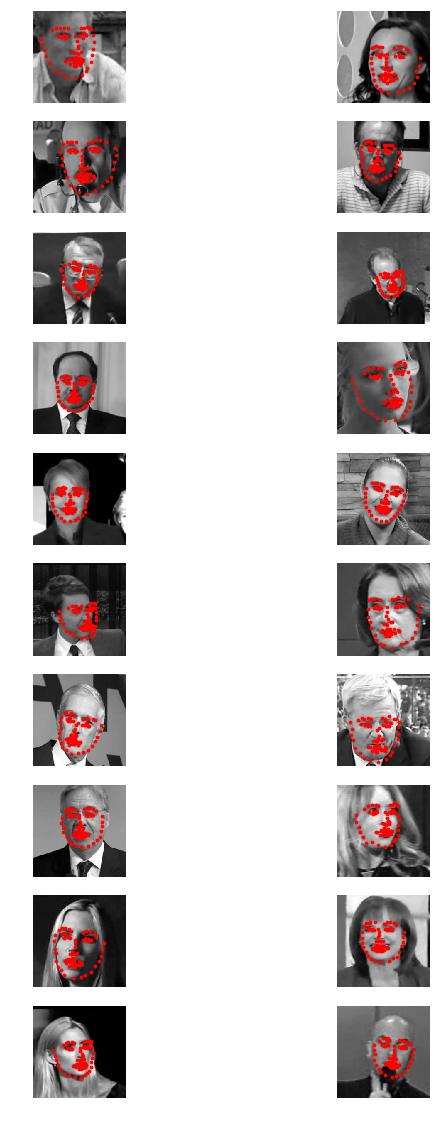

In [18]:
# plot test data with out right labels 
visualize_output(images,outs,batch_size,gray=True)

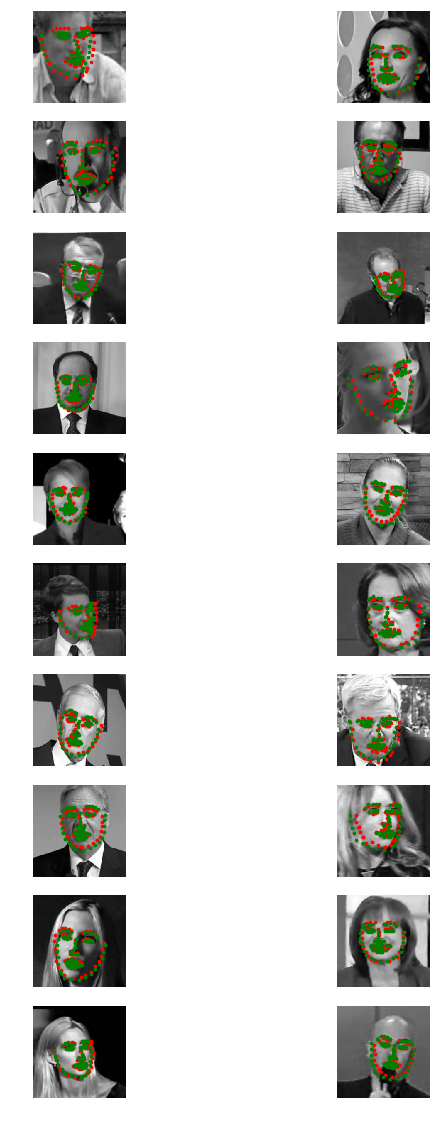

In [19]:
# plot test data with right labels , predicted = red dots , right = green dots
visualize_output(images,outs,batch_size,gt=keypts,gray=True)

## next step in this project:
    * add face detection then find keypoints for all detected face in the image
    * make model work in real time web cam.